# Real-time analysis of computing heart rate using FHE

The graphs shown below were generated using this laptop :

| Nom             | Microsoft Surface Book 2                        |
|-----------------|-------------------------------------------------|
| Processeur      | Core i7 8th Gen - 1.90 GHz - 4 Core - 8 Threads |
| RAM             | 16Go DDR3                                       |
| Carte graphique | _disabled_                                      |
| OS              | Arch Linux                                      |

In [2]:
import numpy as np
from concrete import fhe
from time import perf_counter
import matplotlib.pyplot as plt

In [3]:
# Load r peaks from the ECG No. 107
coord_x_r_peaks = np.array(np.load('Pan_Tompkins_QRS_Detection/extracted_data/coord_x_r_peaks_no_107.npy'))

In [4]:
def extend_ECG_signal(list, time_to_repeat):
    """
    Extend the ECG signal by repeating its own values.
    /!\ Extending an ECG signal will completely distort its values and the analysis of the data it contains.
    In this context, it is only used to test the FHE circuit with a large number of R peaks.

    Parameters
    ----------
    list : The list to extend
    time_to_repeat : The number of time to repeat the list

    Returns
    -------
    list : The extended list
    """

    list = np.array(list)
    for _ in range(time_to_repeat):
        size = len(list)
        list = np.append(list, list+list[size-1])
    return list

def compute_heart_rate(list, fs=360, verbose = False):
    """
    Compute the heart rate from a list of R peaks intervals.

    Parameters
    ----------
    list : The list of R peaks intervals
    fs : The sampling frequency (Hz)
    verbose : If True, print the results

    Returns
    -------
    heartRate : The heart rate
    """

    # Calculate the heart rate
    heartRate = (60*fs)/np.average(list[1:])

    if verbose:
        print("------------------------------------")
        print("ECG signal Heart Rate : ",heartRate, "BPM")
        print("ECG signal number of R peaks : ",len(list)+1) # +1 because for a RRI, there are two R peaks
        print("ECG signal max distance between two R peaks :")
        print("     - in seconds : ",np.max(list)/fs)
        print("     - with axis x : ",np.max(list))
        print("------------------------------------")

def compute_fhe_elapsed_time_specific_inputs(list, fs=360, verbose = False):
        
    list_size = len(list)

    # Max value rounded to 50
    sub_list_max_value = np.max(list)
    sub_list_max_value_rounded = sub_list_max_value + (50 - sub_list_max_value % 50)

    # The FHE circuit need to be compiled each time with a different inputset
    # that is why we need to put the declaration of the function inside the loop
    @fhe.compiler({"r_peaks": "encrypted"})
    def compute_heart_rate_fhe(r_peaks):

        array_len = r_peaks.size
        peaks_mean = np.floor_divide(sum(r_peaks[1:]) , (array_len-1))
        real_fs = np.multiply(60,fs)
        heart_rate = np.floor_divide(real_fs, peaks_mean)
    
        return heart_rate

    inputset = [np.random.randint(sub_list_max_value_rounded, size=list_size), np.random.randint(sub_list_max_value_rounded, size=list_size),np.random.randint(sub_list_max_value_rounded, size=list_size)]
    
    t1_start = perf_counter()
    # Evaluate the circuit with expected random values
    circuit = compute_heart_rate_fhe.compile(inputset)
    t1_stop = perf_counter()
    evaluation_elapsed_time = t1_stop-t1_start

    t1_start = perf_counter()
    # Generate the keys
    # seed of 0 will result in a crypto secure randomly generated 128-bit seed (see keys.py)
    circuit.keys.generate(seed=0)
    t1_stop = perf_counter()
    key_generation_elapsed_time = t1_stop-t1_start

    t1_start = perf_counter()
    # Encrypt the ECG signal
    encrypted_data = circuit.run(circuit.encrypt(list))
    t1_stop = perf_counter()
    encryption_elapsed_time = t1_stop-t1_start

    t1_start = perf_counter()
    # Decrypt the ECG signal
    clear_data = circuit.decrypt(encrypted_data)
    t1_stop = perf_counter()
    decryption_elapsed_time = t1_stop-t1_start

    if verbose:
        print("------------------------------------")
        print("Evaluation elapsed time (sec) : ",evaluation_elapsed_time)
        print("Key generation elapsed time (sec) : ",key_generation_elapsed_time)
        print("Encryption elapsed time (sec) : ",encryption_elapsed_time)
        print("Decryption elapsed time (sec) : ",decryption_elapsed_time)
        print("Total elapsed time (sec) : ",evaluation_elapsed_time+
                                            key_generation_elapsed_time+
                                            encryption_elapsed_time+
                                            decryption_elapsed_time)
        print("ECG signal max RRI value rounded to 50 : ",sub_list_max_value_rounded)
        print("ECG signal number of R peaks : ",list_size+1) # +1 because for a RRI, there are two R peaks
        print("homomorphic evaluation (heart_rate in bpm): ",clear_data)
        print("------------------------------------")

    return evaluation_elapsed_time, key_generation_elapsed_time, encryption_elapsed_time, decryption_elapsed_time

In [5]:
# Sometime this cell must be run twice

list_of_multiple_size_r_peaks = []

short_size_rri = np.diff(coord_x_r_peaks[:3])
normal_size_rri = np.diff(coord_x_r_peaks)
long_size_rri = np.diff(extend_ECG_signal(coord_x_r_peaks, 2))
very_long_size_rri = np.diff(extend_ECG_signal(coord_x_r_peaks, 3))
very_very_long_size_rri = np.diff(extend_ECG_signal(coord_x_r_peaks, 4))

compute_heart_rate(short_size_rri, verbose=True)
compute_heart_rate(normal_size_rri, verbose=True)
compute_heart_rate(long_size_rri)
compute_heart_rate(very_long_size_rri)
compute_heart_rate(very_very_long_size_rri, verbose=True)

------------------------------------
ECG signal Heart Rate :  123.42857142857143 BPM
ECG signal number of R peaks :  3
ECG signal max distance between two R peaks :
     - in seconds :  0.4861111111111111
     - with axis x :  175
------------------------------------
------------------------------------
ECG signal Heart Rate :  78.47959754052543 BPM
ECG signal number of R peaks :  15
ECG signal max distance between two R peaks :
     - in seconds :  0.8916666666666667
     - with axis x :  321
------------------------------------
------------------------------------
ECG signal Heart Rate :  85.11540117222424 BPM
ECG signal number of R peaks :  240
ECG signal max distance between two R peaks :
     - in seconds :  0.8916666666666667
     - with axis x :  321
------------------------------------


In [6]:
short_size_r_peaks_elapsed_time = compute_fhe_elapsed_time_specific_inputs(short_size_rri, verbose=True)
normal_size_r_peaks_elapsed_time = compute_fhe_elapsed_time_specific_inputs(normal_size_rri, verbose=True)
long_size_r_peaks_elapsed_time = compute_fhe_elapsed_time_specific_inputs(long_size_rri)
very_long_size_r_peaks_elapsed_time = compute_fhe_elapsed_time_specific_inputs(very_long_size_rri)
very_very_long_size_r_peaks_elapsed_time = compute_fhe_elapsed_time_specific_inputs(very_very_long_size_rri, verbose=True)

------------------------------------
Evaluation elapsed time (sec) :  2.574548849999985
Key generation elapsed time (sec) :  16.50587248100001
Encryption elapsed time (sec) :  10.329718350000007
Decryption elapsed time (sec) :  5.7168000012097764e-05
Total elapsed time (sec) :  29.410196849000016
ECG signal max RRI value rounded to 50 :  200
ECG signal number of R peaks :  3
homomorphic evaluation (heart_rate in bpm):  123
------------------------------------
------------------------------------
Evaluation elapsed time (sec) :  2.2467321409999954
Key generation elapsed time (sec) :  23.531564781999975
Encryption elapsed time (sec) :  18.079173037000004
Decryption elapsed time (sec) :  8.736200001635552e-05
Total elapsed time (sec) :  43.85755732199999
ECG signal max RRI value rounded to 50 :  350
ECG signal number of R peaks :  15
homomorphic evaluation (heart_rate in bpm):  78
------------------------------------
------------------------------------
Evaluation elapsed time (sec) :  10

In [7]:
list_of_multiple_size_r_peaks = [
    short_size_rri,
    normal_size_rri, 
    long_size_rri, 
    very_long_size_rri, 
    very_very_long_size_rri]

list_of_evaluation_elapsed_time = [
    short_size_r_peaks_elapsed_time[0],
    normal_size_r_peaks_elapsed_time[0],
    long_size_r_peaks_elapsed_time[0],
    very_long_size_r_peaks_elapsed_time[0],
    very_very_long_size_r_peaks_elapsed_time[0]]

list_of_key_generation_elapsed_time = [
    short_size_r_peaks_elapsed_time[1],
    normal_size_r_peaks_elapsed_time[1],
    long_size_r_peaks_elapsed_time[1],
    very_long_size_r_peaks_elapsed_time[1],
    very_very_long_size_r_peaks_elapsed_time[1]]

list_of_encryption_elapsed_time = [
    short_size_r_peaks_elapsed_time[2],
    normal_size_r_peaks_elapsed_time[2],
    long_size_r_peaks_elapsed_time[2],
    very_long_size_r_peaks_elapsed_time[2],
    very_very_long_size_r_peaks_elapsed_time[2]]

list_of_decryption_elapsed_time = [
    short_size_r_peaks_elapsed_time[3],
    normal_size_r_peaks_elapsed_time[3],
    long_size_r_peaks_elapsed_time[3],
    very_long_size_r_peaks_elapsed_time[3],
    very_very_long_size_r_peaks_elapsed_time[3]]

In [23]:
print(list_of_encryption_elapsed_time)

[10.329718350000007, 18.079173037000004, 25.984771086999984, 33.44392388799997, 38.18312414600001]


## Plot conclusion

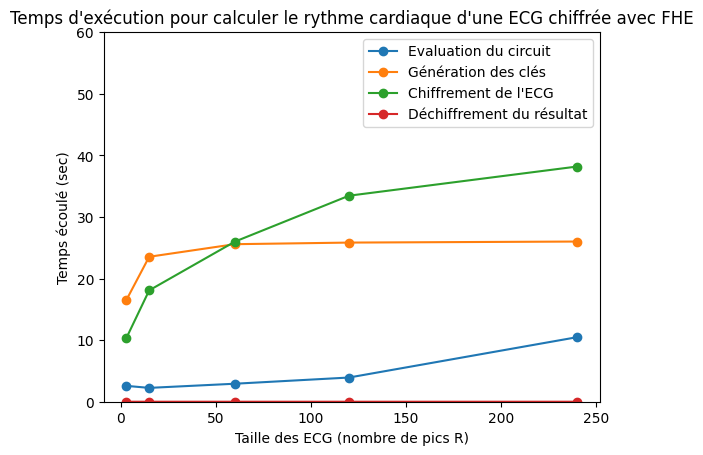

In [37]:
# Plot creation
plt.plot([len(sub_list)+1 for sub_list in list_of_multiple_size_r_peaks], list_of_evaluation_elapsed_time, marker='o', label='Evaluation du circuit')
plt.plot([len(sub_list)+1 for sub_list in list_of_multiple_size_r_peaks], list_of_key_generation_elapsed_time, marker='o', label='Génération des clés')
plt.plot([len(sub_list)+1 for sub_list in list_of_multiple_size_r_peaks], list_of_encryption_elapsed_time, marker='o', label='Chiffrement de l\'ECG')
plt.plot([len(sub_list)+1 for sub_list in list_of_multiple_size_r_peaks], list_of_decryption_elapsed_time, marker='o', label='Déchiffrement du résultat')
# +1 because for a RRI, there are two R peaks

# Axes configuration
plt.xlabel('Taille des ECG (nombre de pics R)')
plt.ylabel('Temps écoulé (sec)')
plt.title('Temps d\'exécution pour calculer le rythme cardiaque d\'une ECG chiffrée avec FHE')

plt.ylim(0,60) # Define the upper and lower limit of the Y axis to 0 et 60

# Plot Legend
plt.legend()

# show the plot
plt.show()

## Seconde analyse
Dans cette seconde analyse, le but est de voir précisement l'impact de différentes opérations réalisées sur des mêmes inputs dans les fonctions FHE. 

In [9]:
def compute_fhe_elapsed_time_specific_operations(fhe_func, inputset, clear_inpute_data):
    t1_start = perf_counter()
    # Evaluate the circuit with expected random values
    circuit = fhe_func.compile(inputset)
    t1_stop = perf_counter()
    evaluation_elapsed_time = t1_stop-t1_start

    t1_start = perf_counter()
    # Generate the keys
    # seed of 0 will result in a crypto secure randomly generated 128-bit seed (see keys.py)
    circuit.keys.generate(seed=0)
    t1_stop = perf_counter()
    key_generation_elapsed_time = t1_stop-t1_start

    t1_start = perf_counter()

    # Encrypt the ECG signal
    match len(clear_inpute_data):
        case 1:
            encrypted_data = circuit.run(circuit.encrypt(clear_inpute_data[0]))
        case 2:
            encrypted_data = circuit.run(circuit.encrypt(clear_inpute_data[0], clear_inpute_data[1]))
        case _:
            # Raise a ValueError exception
            raise ValueError("Invalid input data")

    t1_stop = perf_counter()
    encryption_elapsed_time = t1_stop-t1_start

    t1_start = perf_counter()
    # Decrypt the ECG signal
    clear_data = circuit.decrypt(encrypted_data)
    t1_stop = perf_counter()
    decryption_elapsed_time = t1_stop-t1_start

    print("clear_data : ",clear_data)

    return clear_data, evaluation_elapsed_time, key_generation_elapsed_time, encryption_elapsed_time, decryption_elapsed_time

In [10]:
inputset = [np.random.randint(3500, size=15), np.random.randint(3500, size=15),np.random.randint(3500, size=15)]

First operation : Compute RRI from ECG

In [11]:
array_len = len(coord_x_r_peaks)

@fhe.compiler({"r_peaks": "encrypted"})
def cumpute_diff_fhe(r_peaks):
    for i in range(array_len-1):
        r_peaks[i] = r_peaks[i+1]-r_peaks[i]
    return r_peaks

test1 = compute_fhe_elapsed_time_specific_operations(cumpute_diff_fhe, inputset, [coord_x_r_peaks])

clear_data :  [ 122  175  125  191  321  313  301  298  297  306  312  314  314  311
 3788]


Second operation : Compute RRI and the ECG size inside the function

In [12]:
@fhe.compiler({"r_peaks": "encrypted"})
def cumpute_diff_fhe(r_peaks):

    array_len = r_peaks.size

    for i in range(array_len-1):
        r_peaks[i] = r_peaks[i+1]-r_peaks[i]
    return r_peaks

test2 = compute_fhe_elapsed_time_specific_operations(cumpute_diff_fhe, inputset, [coord_x_r_peaks])


clear_data :  [ 122  175  125  191  321  313  301  298  297  306  312  314  314  311
 3788]


In [13]:
inputset = [np.random.randint(350, size=14), np.random.randint(350, size=14),np.random.randint(350, size=14)]
rri = np.diff(coord_x_r_peaks)

Third operation : Compute the RRI mean and the ECG size inside the function

In [14]:
@fhe.compiler({"rri": "encrypted"})
def cumpute_mean_fhe(rri):

    array_len = rri.size

    peaks_mean = np.floor_divide(sum(rri) , (array_len))

    return peaks_mean

test3 = compute_fhe_elapsed_time_specific_operations(cumpute_mean_fhe, inputset, [rri])

clear_data :  264


In [26]:
inputset = [np.random.randint(3500, size=15), np.random.randint(3500, size=15),np.random.randint(3500, size=15)]

Fourth operation : Compute the RRI, the RRI mean and the ECG size inside the function

In [27]:
@fhe.compiler({"r_peaks": "encrypted"})
def cumpute_mean_fhe(r_peaks):

    array_len = r_peaks.size

    for i in range(array_len-1):
        r_peaks[i] = r_peaks[i+1]-r_peaks[i]

    peaks_mean = np.floor_divide(sum(r_peaks[1:-1]) , (array_len-2))

    return peaks_mean

test4 = compute_fhe_elapsed_time_specific_operations(cumpute_mean_fhe, inputset, [coord_x_r_peaks])

clear_data :  275


Fifth operation : Compute the RRI, the RRI mean, the heart rate and the ECG size inside the function

In [29]:
# Sampling frequency (Hz)
freq_sampling = 360


@fhe.compiler({"r_peaks": "encrypted"})
def cumpute_heart_rate_fhe(r_peaks):

    array_len = r_peaks.size

    for i in range(array_len-1):
        r_peaks[i] = r_peaks[i+1]-r_peaks[i]

    peaks_mean = np.floor_divide(sum(r_peaks[1:-1]) , (array_len-2))

    real_fs = np.multiply(60,freq_sampling)

    heart_rate = np.floor_divide(real_fs, peaks_mean)

    return heart_rate

test5 = compute_fhe_elapsed_time_specific_operations(cumpute_heart_rate_fhe, inputset, [coord_x_r_peaks])

clear_data :  78


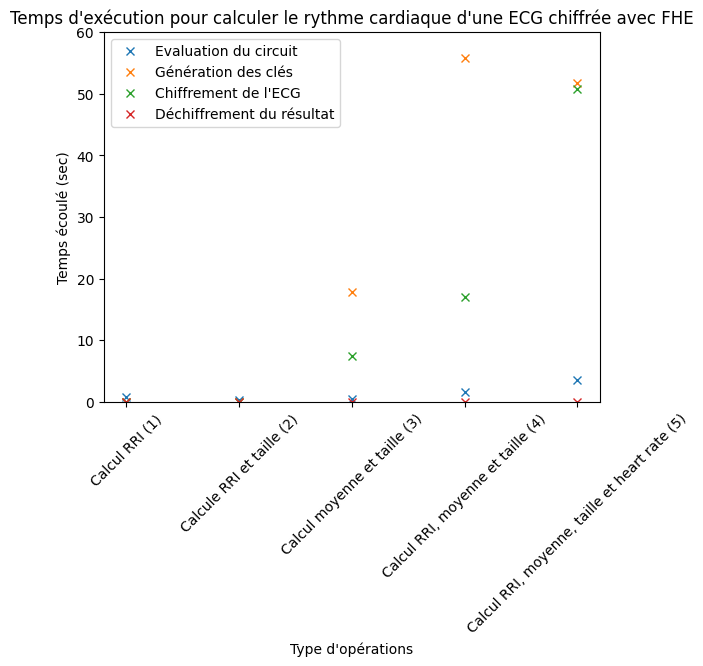

In [34]:
axe_x = ["Calcul RRI (1)","Calcule RRI et taille (2)","Calcul moyenne et taille (3)","Calcul RRI, moyenne et taille (4)","Calcul RRI, moyenne, taille et heart rate (5)"]

plt.plot(axe_x, [test1[1],test2[1],test3[1],test4[1],test5[1]], marker='x', label='Evaluation du circuit', linestyle = 'None')
plt.plot(axe_x, [test1[2],test2[2],test3[2],test4[2],test5[2]], marker='x', label='Génération des clés', linestyle = 'None')
plt.plot(axe_x, [test1[3],test2[3],test3[3],test4[3],test5[3]], marker='x', label='Chiffrement de l\'ECG', linestyle = 'None')
plt.plot(axe_x, [test1[4],test2[4],test3[4],test4[4],test5[4]], marker='x', label='Déchiffrement du résultat', linestyle = 'None')

# Configuration des axes
plt.xlabel('Type d\'opérations')
plt.ylabel('Temps écoulé (sec)')
plt.title('Temps d\'exécution pour calculer le rythme cardiaque d\'une ECG chiffrée avec FHE')

plt.xticks(rotation=45)

plt.ylim(0,60)  # Définit la limite inférieure et supérieur de l'axe Y à 0

# Légende du graphe
plt.legend()

# Affichage du graphe
plt.show()